In [1]:
#general packages for data manipulation
import sklearn 
import numpy as np
import pandas as pd

#visualizations
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

#consistent size plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12

#handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#display pandas dataframe columns 
pd.options.display.max_columns = None

#get reproducible results
np.random.seed(42)
#tf.random.set_seed(42)


# Load the sklearn stuff

# making text data numeric
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# making numeric data comparable
from sklearn.preprocessing import StandardScaler

# experimental regime and pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# machine learning algorithm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [44]:
# For Neural models in Colab:

#from google.colab import drive
#drive.mount('/content/drive')
#
#!ls drive

In [45]:
data_path = 'OLIDv1.0_sharedtask/olid-training-v1.0.tsv'
OLID_train = pd.read_csv(data_path, delimiter='\t', encoding='utf-8')
OLID_train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [46]:
OLID_train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) # rename columns if necessary
OLID_train['target'] = OLID_train.label.map({'NOT':0, 'OFF':1}) # convert label to a numerical variable
OLID_train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) # drop irrelevant columns
OLID_train.head()

#create a copy of the original data to work with 
df = OLID_train.copy()
df.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [47]:
# Check for missing values
df.isnull().sum()

id        0
text      0
label     0
target    0
dtype: int64

In [48]:
# Check for duplicates
df.duplicated().sum()

0

In [49]:
#distributions
df_Stat=df[['label','text']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,NOT,8840,66.767372
1,OFF,4400,33.232628


In [50]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

df['clean'] = df['text'].apply(lambda x: clean(x))
df.head()

[nltk_data] Downloading package stopwords to /Users/Aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


(11916, 2) (1324, 2) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       884
           1       0.73      0.47      0.58       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.76      0.77      0.75      1324



,888,756,1164,554,1055,859,1205,1283,774,413,1106,344,390,680,233,1261,651,303
true,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0
pred,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0


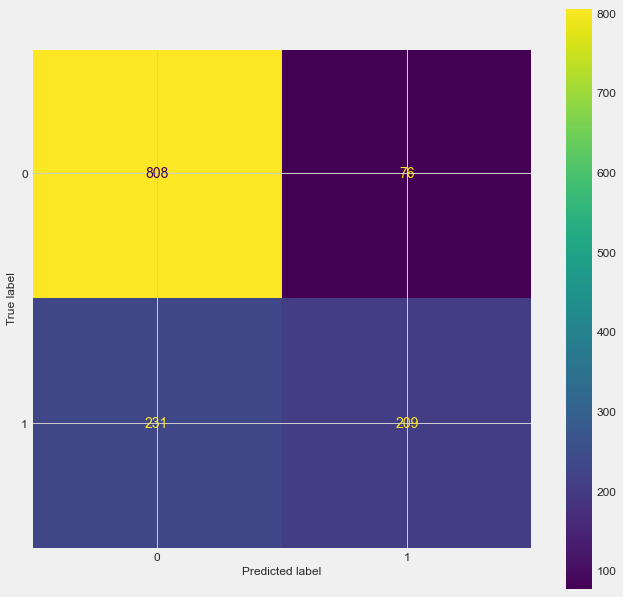

In [53]:
## SGD classifier with tf-idf weighted BoW
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (tfidf_vect, 'clean'),
    remainder = 'drop')

# we use an SGDClassifier
clf = SGDClassifier(random_state=42)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

## Feature Engineering

### VADER sentiment

In [71]:
import nltk
nltk.download(['vader_lexicon'])
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['text']]
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Aron/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,text,label,target,clean,compound,neg,neu,pos,prof,prof_prob
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take,0.0000,0.000,1.000,0.00,0,0.027195
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url,-0.5067,0.247,0.753,0.00,0,0.031362
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...,0.3400,0.000,0.880,0.12,0,0.065642
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano,-0.5574,0.286,0.714,0.00,1,0.982132
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...,0.0000,0.000,1.000,0.00,0,0.066536


### Profanity

In [72]:
#!pip install alt-profanity-check
#!pip install sklearn --upgrade

In [73]:
from profanity_check import predict, predict_prob

df['prof'] = predict(df['text'])
df['prof_prob'] = predict_prob(df['text'])
df.head()

,id,text,label,target,clean,compound,neg,neu,pos,prof,prof_prob
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take,0.0000,0.000,1.000,0.00,0,0.044216
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url,-0.5067,0.247,0.753,0.00,0,0.062316
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...,0.3400,0.000,0.880,0.12,0,0.098105
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano,-0.5574,0.286,0.714,0.00,1,0.982132
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...,0.0000,0.000,1.000,0.00,0,0.140452


(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       884
           1       0.64      0.65      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.74      0.74      1324
weighted avg       0.77      0.77      0.77      1324



,48,747,746,280,805,164,273,1306,75,296,540,1316,469,571,1065,1009,266,787
true,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
pred,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0


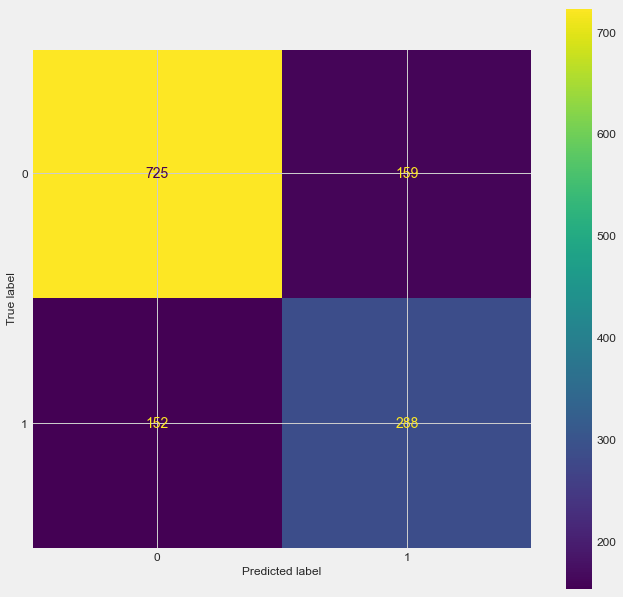

In [99]:
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # APPLYING FEATURE EXTRACTION BEFORE CLEANING GIVES +1 macro-F1!!!
     (scaler, ['prof', 'prof_prob']),             # APPLYING FEATURE EXTRACTION BEFORE CLEANING GIVES +1 macro-F1!!!
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'), # decent results IF lemmatization disabled; otherwise, better left out (cf. count_vect)
    remainder = 'drop')


# We use an SGDClassifier
clf = SGDClassifier(random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

In [251]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
# 'f1_macro' for binary classification gives f1 for positive class
print(scores)
print('\n')
print(f"Mean {scores.mean()}, Std {scores.std()}")

# returns average macro-f1 score over 10 folds (no control over stratification, etc.) -> stratified k-fold = better
# consistent scores with small standard deviations indicate that the model is not overfitting on the train data

[0.72150912 0.75037707 0.74371952 0.74371952 0.72743752 0.73855951
 0.74634702 0.73427423 0.73652255 0.73658444]


Mean 0.737905050928573, Std 0.008307205281010633


In [252]:
pipe.named_steps

{'columntransformer': ColumnTransformer(transformers=[('standardscaler-1', StandardScaler(),
                                  ['compound', 'neg', 'neu', 'pos']),
                                 ('standardscaler-2', StandardScaler(),
                                  ['prof', 'prof_prob']),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(ngram_range=(1, 2),
                                                  stop_words='english'),
                                  'clean')]),
 'sgdclassifier': SGDClassifier(class_weight='balanced', random_state=42)}

In [256]:
params = [{
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4), (1, 6), (2, 7)],
    'sgdclassifier__loss': ['hinge', 'log'] # with hinge it's an svm, with log it's logistic regression
    }]

gs = GridSearchCV(pipe, params, n_jobs=-1, cv=5, verbose=1, scoring='f1_macro')
gs.fit(X, y)

# F1 = harmonic mean of precision and recall; macro = average thereof
# Note: in binary classification this only apllies to positive the class

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler-1',
                                                                         StandardScaler(),
                                                                         ['compound',
                                                                          'neg',
                                                                          'neu',
                                                                          'pos']),
                                                                        ('standardscaler-2',
                                                                         StandardScaler(),
                                                                         ['prof',
                                                                          'prof_prob']),
                                                  

In [257]:
print(gs.best_score_)  # top score
print(gs.best_params_) # best param settings -> GridSearch for hyper-parameter tuning once a model has been decided

0.7401540722259139
{'columntransformer__tfidfvectorizer__ngram_range': (1, 2), 'sgdclassifier__loss': 'log'}


(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       884
           1       0.63      0.62      0.63       440

    accuracy                           0.76      1324
   macro avg       0.72      0.72      0.72      1324
weighted avg       0.75      0.76      0.75      1324



,383,498,254,872,708,1176,729,285,20,958,494,1260,1056,385,184,1094,1305,631
true,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
pred,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


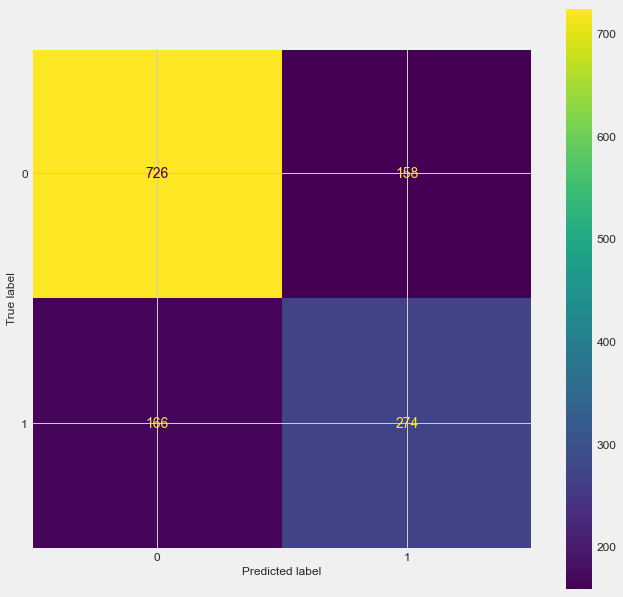

In [23]:
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')


# We use an SGDClassifier
clf = SGDClassifier(random_state=42, class_weight='balanced', loss='log')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

In [ ]:
# Some other models:

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       884
           1       0.71      0.49      0.58       440

    accuracy                           0.76      1324
   macro avg       0.74      0.69      0.71      1324
weighted avg       0.75      0.76      0.75      1324



,81,1172,1161,175,247,416,653,446,348,851,381,805,1028,910,732,1062,359,16
true,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
pred,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1


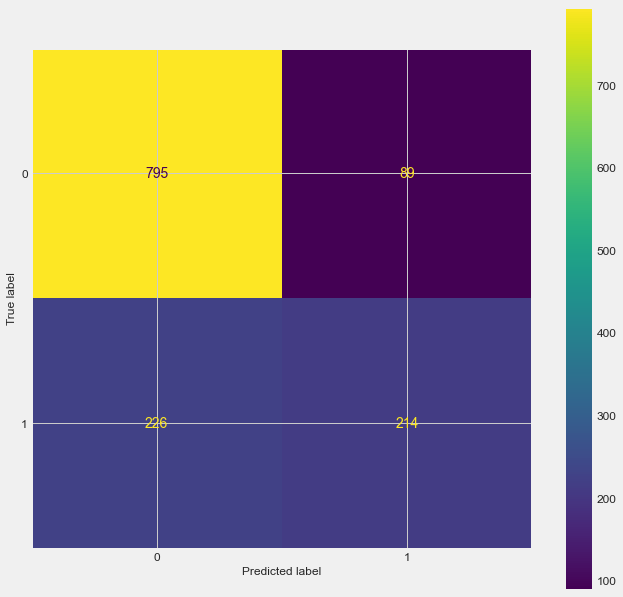

In [174]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1500)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

log_pipe = make_pipeline(preprocessor, clf)

log_pipe.fit(X_train, y_train)
y_test_pred = log_pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=log_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       884
           1       0.75      0.45      0.57       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.77      0.77      0.75      1324



,973,692,125,1116,542,1029,121,373,290,1253,844,1282,306,194,219,852,1312,1317
true,1,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0
pred,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


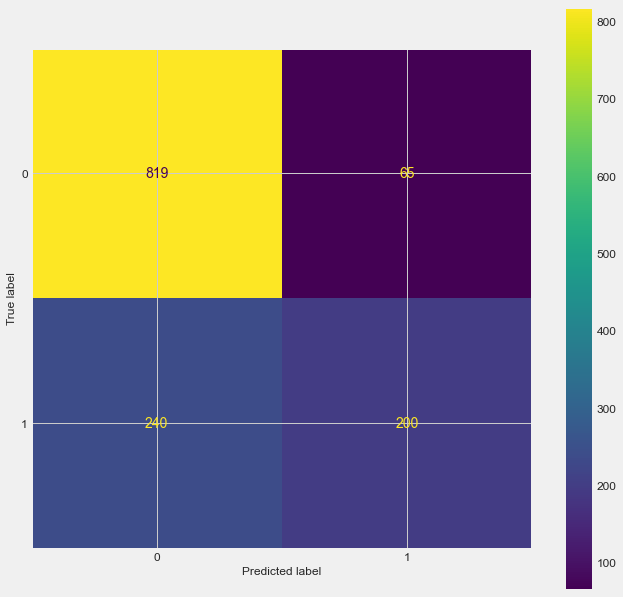

In [176]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

clf = RandomForestClassifier(random_state=42, class_weight='balanced')

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_test_pred = svm_pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       884
           1       0.64      0.61      0.63       440

    accuracy                           0.76      1324
   macro avg       0.73      0.72      0.72      1324
weighted avg       0.75      0.76      0.76      1324



,1088,78,735,690,475,728,1043,495,127,1297,0,1172,874,706,722,215,159,401
true,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
pred,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0


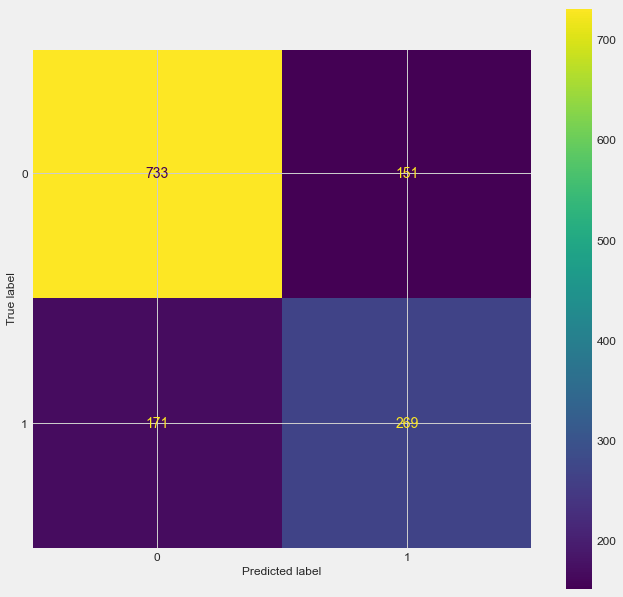

In [188]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_test_pred = svm_pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       884
           1       0.69      0.52      0.59       440

    accuracy                           0.76      1324
   macro avg       0.74      0.70      0.71      1324
weighted avg       0.75      0.76      0.75      1324



,1177,727,790,499,800,925,868,1229,476,1140,901,335,884,238,904,313,702,281
true,1,0,1,0,0,1,1,1,0,1,1,1,0,0,0,0,1,0
pred,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0


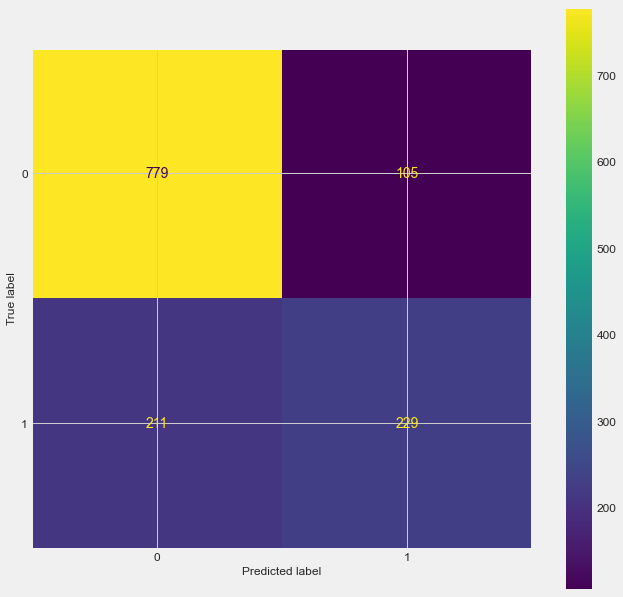

In [194]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(15)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_test_pred = svm_pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       884
           1       0.65      0.64      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.73      0.74      1324
weighted avg       0.77      0.77      0.77      1324



,987,335,1136,307,895,1142,966,1086,337,765,117,1077,923,356,692,991,533,55
true,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
pred,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0


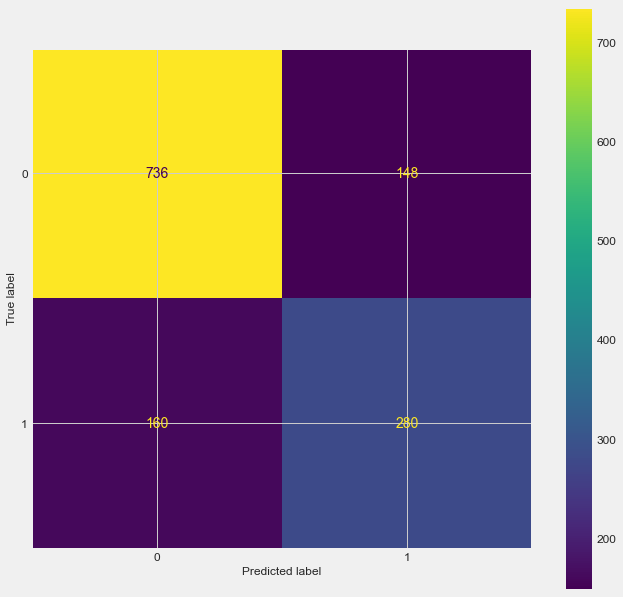

In [198]:
from sklearn.svm import LinearSVC # Linear gave better results than regular SVC (with rbf kernel)

clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=1500)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_test_pred = svm_pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_test)
preds = np.array(y_test_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

In [196]:
# Linear SVC appears to be the best, but we should verify by taking the top model(s) and doing CVs and GridSearch!

### At first sight it seems that new information sources can improve upon the bag of word approach, but we should optimize each experiment using *cross-validation and hyper-parameter optimization* before drawing conclusions. At that point we can also *use the real test set and compare the architectures* with the different optimized parameters on the test data for final conclusions.

_Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and **linear SVMs might lead to better generalization than is achieved by other classifiers**._